Generated random sequences to test with:

10aa: 0011001110 (HHPPHHPPPH)
20aa: 01110000010010001001 (HPPPHHHHHPHHPHHHPHHP)

In [241]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

In [270]:
#@jit(nopython = True)
def changepositions(AApositions, chainlength):
    '''
    Performs a new self-avoiding random walk from a residue selected at random.
    '''
    pivotpoint = np.random.randint(0, chainlength)
    
    AApositions_new = np.copy(AApositions)
    
    x = [AApositions_new[0, pivotpoint, 0]]
    y = [AApositions_new[0, pivotpoint, 1]]
    bonds = []
  
    #print("starting point of step is ", AApositions_new[0, pivotpoint, 0], AApositions_new[0, pivotpoint, 1])
    positions = set()
    for i in range(pivotpoint+1):
        positions.add((AApositions_new[0, i, 0], AApositions_new[0, i, 1]))
    
    #print(pivotpoint)
    #print(positions)
    stuck = 0
    
    for i in range(chainlength-pivotpoint-1):
        deltas = [(1,0), (0,1), (-1,0), (0,-1)]
        deltas_feasible = []  #deltas_feasible stores the available directions 
        for dx, dy in deltas:
            if (x[-1] + dx, y[-1] + dy) not in positions:  #checks if direction leads to a site notvisited before
                deltas_feasible.append((dx,dy))
        if deltas_feasible:  #checks if there is a direction available
            dx, dy = deltas_feasible[np.random.randint(0,len(deltas_feasible))]  #choose a direction at random among available ones
            positions.add((x[-1] + dx, y[-1] + dy))
            x.append(x[-1] + dx)
            y.append(y[-1] + dy)
            if ((dx, dy) == (1,0)):
                bonds.append(1)
            if ((dx, dy) == (0, 1)):
                bonds.append(2)
            if ((dx, dy) == (-1, 0)):
                bonds.append(3)
            if ((dx, dy) == (0, -1)):
                bonds.append(4)
        
        else:  #in that case the walk is stuck
            stuck = 1
            steps = i+1
            return AApositions, AApositions
            break
            #terminate the walk prematurely
        #steps = chainlength-1
        
    np.array(x)
    np.array(y)
    bonds.append(0)
    np.array(bonds)
    
    #print(x)
    #print(y)
    
    for i in range(chainlength-pivotpoint):
        AApositions_new[0, pivotpoint+i, 0] = x[i]
        AApositions_new[0, pivotpoint+i, 1] = y[i]
        AApositions_new[0, pivotpoint+i, 2] = bonds[i]
    
    #print(pivotpoint)

    return AApositions, AApositions_new

def stateLattice(L, chainlength, AApositions):
    '''
    Locates positions of hydrophobic residues on entire lattice
    '''
    state = np.zeros((L, L), int)
    for i in range(chainlength):
        state[int(AApositions[0, i, 0]), int(AApositions[0, i,1])] = AApositions[0, i,3]
    
    return state

#@jit(nopython = True)
def totalEnergy(state, L):
        '''
        Sums interactions on state lattice to calculate total energy. Divides sum by two because each interaction
        is double counted (once for [i, j] and once for [j, i]).
        '''
        E_list = [] 
        L1 = L-1
        for i in range(L):
            for j in range(L):
                E = -state[i, j] * (state[(i+1)%L, j] + state[(i+L1)%L, j] + state[i, (j+1)%L] + state[i, (j+L1)%L])
                E_list.append(E)
        np.array(E_list)
        totalEnergy = np.sum(E_list)/2

        return totalEnergy

#@jit(nopython = True)
def momentOfInertia (AApositions, chainlength):
    squaredradii = []
        
    for i in range(chainlength):
        ri = (AApositions[0, i, 0]-10)**2 + (AApositions[0, i, 1]-10)**2
        squaredradii.append(ri)
        
    np.array(squaredradii)
        
    momentOfInertia = np.sum(squaredradii)
        
    return momentOfInertia

In [243]:
#@jit(nopython = True)
def MCstep_jit(L, chainlength, T, AApositions, acceptedMoves, energy):
    
    AApositions, AApositions_new = changepositions(AApositions, chainlength) #make Monte Carlo step by performing self-avoiding random walk from random res. on protein
    
    #Generate state of lattice for old and new protein configuration.
    state_AApositions = stateLattice(L, chainlength, AApositions)
    state_AApositions_new = stateLattice(L, chainlength, AApositions_new)
    
    #Calculate energy of lattice for old and new protein configuration.
    energy_AApositions = totalEnergy(state_AApositions, L)
    energy_AApositions_new = totalEnergy(state_AApositions_new, L)
    
    #Calculate the difference in lattice energy of the two states.
    dE = energy_AApositions_new - energy_AApositions
    
    #Generate a random value to which dE will be compared.
    randomValue = np.random.random()
    if dE <= 0 or np.exp(-dE/T) > randomValue:
        acceptedMoves += 1
        AApositions = AApositions_new
        state = state_AApositions_new
        energy += dE
    
    AA_positions_momentOfInertia = momentOfInertia(AApositions, chainlength)
    
    return AApositions, acceptedMoves, energy, momentOfInertia
    


In [390]:
class Ising2D (object):
    
    def __init__(self, L, chainlength, hydrophobicity, temperature):
        
        self.L = L
        #self.N = L**2
        
        self.chainlength = chainlength
        
        self.hydrophobicity = hydrophobicity
        
        self.temperature = temperature
        
        self.AApositions = self.initialPositions(self.L, self.chainlength, self.hydrophobicity)
        
        self.state = self.stateLattice(self.L, self.chainlength, self.AApositions)
        
        self.energy = self.totalEnergy(self.state, self.L)
        
        self.reset()
        
        self.momentOfInertia = self.MOI(self.AApositions, self.chainlength)
    
    def initialPositions(self, L, chainlength, hydrophobicity):
    
        res1pos = int(L/2)
    
        x, y, bonds = [res1pos], [res1pos], [0]
        positions = set([(res1pos,res1pos)])  #positions is a set that stores all sites visited by the walk
        stuck = 0
        for i in range(chainlength-1):
            deltas = [(1,0), (0,1), (-1,0), (0,-1)]
            deltas_feasible = []  #deltas_feasible stores the available directions 
            for dx, dy in deltas:
                if (x[-1] + dx, y[-1] + dy) not in positions:  #checks if direction leads to a site notvisited before
                    deltas_feasible.append((dx,dy))
            if deltas_feasible:  #checks if there is a direction available
                dx, dy = deltas_feasible[np.random.randint(0,len(deltas_feasible))]  #choose a direction at random among available ones
                positions.add((x[-1] + dx, y[-1] + dy))
                x.append(x[-1] + dx)
                y.append(y[-1] + dy)
                if ((dx, dy) == (1,0)):
                    bonds.append(1)
                if ((dx, dy) == (0, 1)):
                    bonds.append(2)
                if ((dx, dy) == (-1, 0)):
                    bonds.append(3)
                if ((dx, dy) == (0, -1)):
                    bonds.append(4)

            else:  #in that case the walk is stuck
                stuck = 1
                steps = i+1
                break  #terminate the walk prematurely
            steps = chainlength-1
        
        np.array(x)
        np.array(y)
        bonds.pop(0)
        bonds.append(0)
        np.array(bonds)
    
        AApositions = np.dstack([x, y, bonds, hydrophobicity])
    
        return AApositions
    
    def stateLattice(self, L, chainlength, AApositions):
        '''
        Locates positions of hydrophobic residues on entire lattice
        '''
        state = np.zeros((self.L, self.L), int)
        for i in range(chainlength):
            state[int(AApositions[0, i, 0]), int(AApositions[0, i,1])] = AApositions[0, i,3]
        return state
    
    def totalEnergy(self, state, L):
        '''
        Sums interactions on identity lattice to calculate total energy. Divides sum by two because each interaction
        is double counted (once for [i, j] and once for [j, i]).
        '''
        E_list = [] 
        L1 = L-1
        for i in range(L):
            for j in range(L):
                E = -state[i, j] * (state[(i+1)%L, j] + state[(i+L1)%L, j] + state[i, (j+1)%L] + state[i, (j+L1)%L])
                E_list.append(E)
        np.array(E_list)
        totalEnergy = np.sum(E_list)/2

        return totalEnergy
    
    def MOI (self, AApositions, chainlength):
        squaredradii = []
        
        for i in range(chainlength):
            ri = (AApositions[0, i, 0]-10)**2 + (AApositions[0, i, 1]-10)**2
            squaredradii.append(ri)
        
        np.array(squaredradii)
        
        momentOfInertia = np.sum(squaredradii)
        
        return momentOfInertia
    
    def increment_T(self, T_increment, reset = True):
        
        T_new = self.temperature + T_increment
        
        if T_new <= 0:
            T_new = self.temperature
            
        self.temperature = T_new
        if reset:
            self.reset()
    
    def reset(self):
        
        self.monteCarloSteps = 0
        self.acceptedMoves = 0
        self.energyArray = np.array([], int)
        self.momentOfInertiaArray = np.array([], int)
        
    def monteCarloStep(self):
        
        L = self.L
        chainlength = self.chainlength
        T = self.temperature
        AApositions = self.AApositions
        acceptedMoves = self.acceptedMoves
        energy = self.energy 
    
        AApositions, acceptedMoves, energy, momentOfInertia = MCstep_jit(L, chainlength, T, AApositions, acceptedMoves, energy)
        
        self.AApositions = AApositions
        #self.state = state
        self.acceptedMoves = acceptedMoves
        self.energy = energy
        self.momentOfInertia = self.MOI(self.AApositions, self.chainlength)
        
        self.energyArray.append(self.energy)
        self.momentOfInertiaArray.append(self.momentOfInertia)
        self.monteCarloSteps += 1
        
    def steps(self, number = 100):
        
        self.energyArray = self.energyArray.tolist()
        self.momentOfInertiaArray = self.momentOfInertiaArray.tolist()
        
        for k in range(number):
            self.monteCarloStep()
                
        self.energyArray = np.asarray(self.energyArray)
        self.momentOfInertiaArray = np.asarray(self.momentOfInertiaArray)
            
    ##Observables
    def specificHeat(self):
        return (self.energyArray.std() / self.temperature)**2/(self.L**2)
    
    def plot_positions(self, save = False):
        plt.scatter(self.AApositions[0,:, 0], self.AApositions[0,:,1], c = self.AApositions[0, :, 3])
        plt.plot(self.AApositions[0,:, 0], self.AApositions[0,:,1])
        if save:
            plt.savefig("Positions.png")
            
    def plot_totalEnergy(self, save = False):
        steps_array = np.arange(self.monteCarloSteps)
        plt.plot(steps_array, self.energyArray)
        plt.xlabel("Monte Carlo Steps")
        plt.ylabel("Conformational Energy")
        plt.title("Energy vs. Folding Time")
        if save:
            plt.savefig("StepsVsTotalEnergy.png")
            
    def plot_momentOfInertia(self, save = False):
        steps_array = np.arange(self.monteCarloSteps)
        plt.plot(steps_array, self.momentOfInertiaArray)
        plt.xlabel("Monte Carlo Steps")
        plt.ylabel("Moment Of Inertia")
        plt.title("Structure vs. Folding Time")
        if save:
            plt.savefig("StepsVsMomentOfInertia.png")

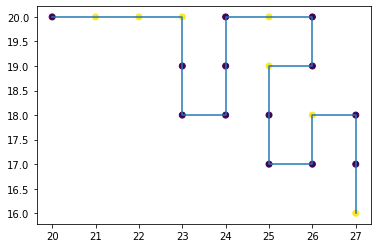

In [406]:
AA_10 = np.array([1, 1, 0, 0, 1, 1, 0, 0, 0, 1])

AA_20 = np.array([0,1,1,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1])

test = Ising2D(L = 40, chainlength = 20, hydrophobicity = AA_20, temperature = 1.5)
test.reset()
test.plot_positions(save = True)




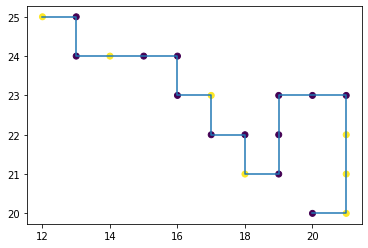

In [407]:
test.steps(1000)
test.plot_positions(save = True)

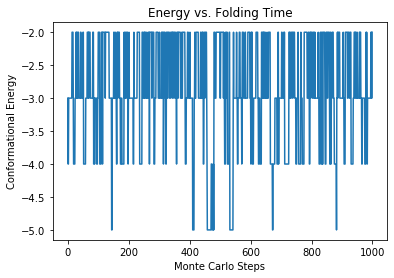

In [409]:
test.plot_totalEnergy(save=True)

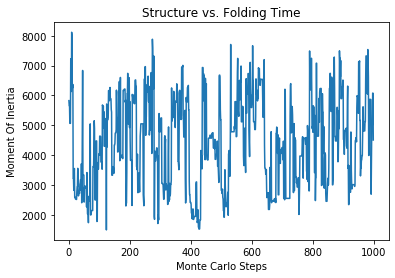

In [410]:
test.plot_momentOfInertia(save = True)

In [421]:
T_array = np.arange(.05, 1, .05)

E_list = []
for i in T_array:
    model = Ising2D(L = 20, chainlength = 10, hydrophobicity = AA_10, temperature = i)
    model.steps(1000)
    E = model.energy
    E_list.append(E)

In [422]:
E_array = np.array(E_list)

dE_dt_list = []
for i in range(len(E_array)-1):
    dE = E_array[i+1] - E_array[i]
    dt = .05
    dE_dt = dE /dt
    dE_dt_list.append(dE_dt)
    


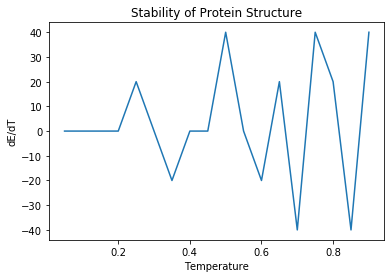

In [424]:
dE_dt_array = np.array(dE_dt_list)
plt.plot(T_array[:-1], dE_dt_array)
plt.xlabel("Temperature")
plt.ylabel("dE/dT")
plt.title("Stability of Protein Structure")
plt.savefig("TemperatureStability")

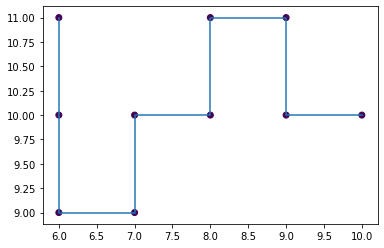

In [436]:
model = Ising2D(L = 20, chainlength = 10, hydrophobicity = np.array([1,1,1,1,1,1,1,1,1,1]), temperature = .1)

model.plot_positions(save = True)

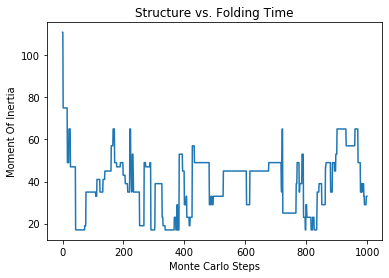

In [434]:
model.plot_momentOfInertia(save = True)